In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 数据读入

In [2]:
churn = pd.read_csv('telecom_churn.csv', skipinitialspace=True)
churn.head()

,subscriberID,churn,gender,AGE,edu_class,incomeCode,duration,feton,peakMinAv,peakMinDiff,posTrend,negTrend,nrProm,prom,curPlan,avgplan,planChange,posPlanChange,negPlanChange,call_10086
0,19164958.0,1.0,0.0,20.0,2.0,12.0,16.0,0.0,113.666667,-8.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,39244924.0,1.0,1.0,20.0,0.0,21.0,5.0,0.0,274.000000,-371.0,0.0,1.0,2.0,1.0,3.0,2.0,2.0,1.0,0.0,1.0
2,39578413.0,1.0,0.0,11.0,1.0,47.0,3.0,0.0,392.000000,-784.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0
3,40992265.0,1.0,0.0,43.0,0.0,4.0,12.0,0.0,31.000000,-76.0,0.0,1.0,2.0,1.0,3.0,3.0,0.0,0.0,0.0,1.0
4,43061957.0,1.0,1.0,60.0,0.0,9.0,14.0,0.0,129.333333,-334.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3463 entries, 0 to 3462
Data columns (total 20 columns):
subscriberID     3463 non-null float64
churn            3463 non-null float64
gender           3463 non-null float64
AGE              3463 non-null float64
edu_class        3463 non-null float64
incomeCode       3463 non-null float64
duration         3463 non-null float64
feton            3463 non-null float64
peakMinAv        3463 non-null float64
peakMinDiff      3463 non-null float64
posTrend         3463 non-null float64
negTrend         3463 non-null float64
nrProm           3463 non-null float64
prom             3463 non-null float64
curPlan          3463 non-null float64
avgplan          3463 non-null float64
planChange       3463 non-null float64
posPlanChange    3463 non-null float64
negPlanChange    3463 non-null float64
call_10086       3463 non-null float64
dtypes: float64(20)
memory usage: 541.2 KB


# 数据探索
简洁版本，只是为了一元逻辑回归做的探索

### churn 流失与否 是否与 posTrend 流量使用上升趋势有关
猜想：posTrend 为 1，即流量使用有上升趋势时，更不容易流失（用得越多越不容易流失）

###### 交叉表分析

In [4]:
cross_table = pd.crosstab(index=churn.posTrend, columns=churn.churn, 
                          margins=True)
cross_table

churn,0.0,1.0,All
posTrend,,,
0.0,829,990,1819
1.0,1100,544,1644
All,1929,1534,3463


In [5]:
# 转化成百分比的形式
def perConvert(ser):
    return ser/float(ser[-1])

cross_table.apply(perConvert, axis='columns') 
    # axis=1 也可以写成 axis='columns', 表示对列使用这个函数
    
# 发现的确如我们所想，流量使用有上升趋势的时候，流失的概率会下降

churn,0.0,1.0,All
posTrend,,,
0.0,0.455745,0.544255,1.0
1.0,0.669100,0.330900,1.0
All,0.557031,0.442969,1.0


###### 卡方检验

In [6]:
print("""chisq = %6.4f
p-value = %6.4f
dof = %i
expected_freq = %s""" % stats.chi2_contingency(observed=cross_table.iloc[:2, :2]))
# iloc 是因为 cross_table 添加了 margin 参数，也就是在最后一行和最后一列都显示 all，
 ## 卡方检验的时候我们只需要传入类别列即可，无需总列
    
# 发现检验结果还是比较显著的，说明 posTrend 这个变量有价值

chisq = 158.4433
p-value = 0.0000
dof = 1
expected_freq = [[1013.24025411  805.75974589]
 [ 915.75974589  728.24025411]]


# 统计学库建模

## 一元逻辑回归

### 拆分测试集与训练集

In [7]:
train = churn.sample(frac=0.7, random_state=1234).copy()
test = churn[~ churn.index.isin(train.index)].copy() 
# ~ 表示取反，isin 表示在不在，这个知识点 pandas 非常常用
print(f'训练集样本量：{len(train)}, 测试集样本量：{len(test)}')

训练集样本量：2424, 测试集样本量：1039


### statsmodels 库进行逻辑回归

In [8]:
# glm: general linear model - 也就是逻辑回归的别称：广义线性回归
lg = smf.glm(formula='churn ~ duration', data=churn,
            family=sm.families.Binomial(sm.families.links.logit)).fit()
            ## family=sm .... logit 这一大行看似难，其实只要是统计学库进行逻辑回归建模，
             ## 都是这样建，families 族群为 Binomial，即伯努利分布(0-1 分布)
lg.summary()
#  下面的一大个表中，只有这些还稍微有点价值，发现两个变量都挺显著，
#     呈现一定的负相关关系，可以先简单理解为，每增加一个单位，流失的概率就下降一点
# 	         coef	stderr	  z	    P>|z|	[0.025	0.975]
# Intercept	3.0207	0.116	26.078	0.000	2.794	3.248
# duration	-0.2488	0.010	-25.955	0.000	-0.268	-0.230

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3463
Model:                            GLM   Df Residuals:                     3461
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1516.2
Date:                Thu, 17 Sep 2020   Deviance:                       3032.3
Time:                        20:14:00   Pearson chi2:                 2.78e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5883      0.100     25.767      0.000       2.391       2.785
duration      -0.2482      0.009    -26.424      0.000      -0.267      -0.230
==============================================================================
"""

### 使用建模结果进行预测
预测流失的可能性

In [9]:
# 预测流失的可能性
train['proba'] = lg.predict(train)
test['proba'] = lg.predict(test)

test[['churn', 'proba']].head() # 我们可以假设 proba > 0.5 就算流失，
# 即如果 churn=1，proba > 0.5，则表示预测正确，当然，这个 proba 需要根据业务实际情况来定

,churn,proba
3,1.0,0.403721
5,0.0,0.587731
7,1.0,0.700772
8,1.0,0.793698
10,0.0,0.526575


In [10]:
# 以 proba > 0.5 就设为流失作为预测结果
test['prediction'] = (test['proba'] > 0.5)*1 
                        # 把 True 和 False 转化成 1 和 0
test[['churn', 'prediction']].sample(5)

,churn,prediction
1917,0.0,0
2918,0.0,0
2909,1.0,1
2735,0.0,1
314,0.0,0


### 检验预测结果

In [11]:
pd.crosstab(index=test.churn, columns=test.prediction, margins=True)

prediction,0,1,All
churn,,,
0.0,427,156,583
1.0,88,368,456
All,515,524,1039


In [12]:
# 计算一下模型预测的准度如何
acc = sum(test['prediction'] == test['churn']) / np.float(len(test))
print(f'The accuracy is: {acc}') 

The accuracy is: 0.7651588065447545


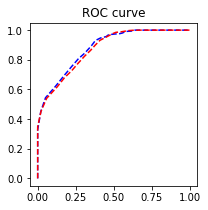

AUC = 0.8790154524389877


In [13]:
# sklearn 包绘制 Python 专门用来评估逻辑回归模型精度的 ROC 曲线
import sklearn.metrics as metrics
fpr_test, tpr_test, th_test = metrics.roc_curve(test.churn, test.proba)
fpr_train, tpr_train, th_train = metrics.roc_curve(train.churn, train.proba)

plt.figure(figsize=[3, 3])
plt.plot(fpr_test, tpr_test, 'b--')
plt.plot(fpr_train, tpr_train, 'r--')
plt.title('ROC curve'); plt.show()

# 还可以，其实越靠近左上角越好

print(f'AUC = {metrics.auc(fpr_test, tpr_test)}')
# 模型精度比较高

## 多元逻辑回归

### 逐步向前法筛选变量
当然，这里的变量还不算特别特别多，还可以使用分层抽样，假设检验，方差分析等方法筛选

这里不用多解释了，逻辑回归的逐步向前法已有优秀前人的轮子，直接拿来用即可

    逐步向前法筛选变量时，线性回归与逻辑回归的代码差别看下面这个代码框的注释即可

In [14]:
def forward_select(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining:
        aic_with_candidates=[]
        for candidate in remaining:
            formula = "{} ~ {}".format(
                response,' + '.join(selected + [candidate]))
            aic = smf.glm(
                formula=formula, data=data, 
                family=sm.families.Binomial(sm.families.links.logit)
                # 多元线性回归与多元逻辑回归的不同
            ).fit().aic
            aic_with_candidates.append((aic, candidate))
        aic_with_candidates.sort(reverse=True)
        best_new_score, best_candidate=aic_with_candidates.pop()
        if current_score > best_new_score: 
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print ('aic is {},continuing!'.format(current_score))
        else:        
            print ('forward selection over!')
            break
            
    formula = "{} ~ {} ".format(response,' + '.join(selected))
    print('final formula is {}'.format(formula))
    model = smf.glm(
        formula=formula, data=data, 
        family=sm.families.Binomial(sm.families.links.logit)
    ).fit()
    return(model)

In [15]:
churn.columns

Index(['subscriberID', 'churn', 'gender', 'AGE', 'edu_class', 'incomeCode',
       'duration', 'feton', 'peakMinAv', 'peakMinDiff', 'posTrend', 'negTrend',
       'nrProm', 'prom', 'curPlan', 'avgplan', 'planChange', 'posPlanChange',
       'negPlanChange', 'call_10086'],
      dtype='object')

In [16]:
# 待放入的变量，除了 subsriberID 没用外，其他都可以放进去看下
candidates = churn.columns.tolist()[1:]
data_for_select = train[candidates]
data_for_select.sample()

,churn,gender,AGE,edu_class,incomeCode,duration,feton,peakMinAv,peakMinDiff,posTrend,negTrend,nrProm,prom,curPlan,avgplan,planChange,posPlanChange,negPlanChange,call_10086
1131,0.0,1.0,27.0,0.0,58.0,9.0,1.0,300.666667,-66.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0


In [17]:
lg_m1 = forward_select(data=data_for_select, response='churn')
lg_m1.summary()

aic is 2139.9815513388403,continuing!
aic is 2015.2487668432518,continuing!
aic is 1881.937082067902,continuing!
aic is 1824.2267798372743,continuing!
aic is 1768.3126157284164,continuing!
aic is 1720.3724820021637,continuing!
aic is 1698.6276836135844,continuing!
aic is 1694.3503537722104,continuing!
aic is 1685.96916823163,continuing!
aic is 1683.5274343084689,continuing!
aic is 1677.5174259811881,continuing!
aic is 1675.025740842283,continuing!
aic is 1674.277814107007,continuing!
forward selection over!
final formula is churn ~ duration + feton + gender + call_10086 + peakMinDiff + edu_class + AGE + prom + nrProm + posTrend + negTrend + peakMinAv + posPlanChange 


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                 2424
Model:                            GLM   Df Residuals:                     2410
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -823.14
Date:                Thu, 17 Sep 2020   Deviance:                       1646.3
Time:                        11:37:34   Pearson chi2:                 1.88e+03
No. Iterations:                     7   Covariance Type:             nonrobust
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.7601      0.470     10.133      0.000       3.839       5.681
duration         -0.2917      0.015    -19.969      0.000      -0.320      -0.263
feton            -1.4144      0.128    -11.012      0.000      -1.666      -1.163
gender            1.4394      0.131     11.012      0.000       1.183       1.696
call_10086       -0.9040      0.126     -7.161      0.000      -1.151      -0.657
peakMinDiff      -0.0024      0.001     -4.625      0.000      -0.003      -0.001
edu_class         0.5434      0.078      6.942      0.000       0.390       0.697
AGE              -0.0195      0.005     -4.255      0.000      -0.029      -0.011
prom              2.3925      0.693      3.451      0.001       1.034       3.751
nrProm           -0.7430      0.248     -2.993      0.003      -1.230      -0.256
posTrend         -1.5598      0.416     -3.747      0.000      -2.376      -0.744
negTrend         -1.3003      0.414     -3.138      0.002      -2.113      -0.488
peakMinAv         0.0011      0.000      2.289      0.022       0.000       0.002
posPlanChange    -1.0211      0.624     -1.637      0.102      -2.244       0.202
=================================================================================
"""

In [18]:
print(f'原来有 {len(candidates)} 个变量')
print(f'筛选剩下 {len(lg_m1.params.index.tolist())} 个(包含 intercept 截距项)。')

原来有 19 个变量
筛选剩下 14 个(包含 intercept 截距项)。


### 方差膨胀因子检测
多元逻辑回归中也有多元共线性

In [19]:
def vif(df, col_i):
    from statsmodels.formula.api import ols
    
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)

In [20]:
after_select = lg_m1.params.index.tolist()[1:] # Intercept 不算
exog = train[after_select]

In [21]:
for i in exog.columns:
    print(i, '\t', vif(df=exog, col_i=i))
# 按照一般规则，大于10的就算全部超标，通常成对出现，只需要删除成对出现的一个即可。
 ## 这里我们挑成对出现中较大的删除

duration 	 1.161504699105813
feton 	 1.0328256567299992
gender 	 1.0133391644017549
call_10086 	 1.031223607502261
peakMinDiff 	 1.751496545110971
edu_class 	 1.0889914844535982
AGE 	 1.0509696212426345
prom 	 10.737528463052845
nrProm 	 10.65776904003062
posTrend 	 10.796864945899232
negTrend 	 10.721360755367623
peakMinAv 	 1.098680725629805
posPlanChange 	 1.0556555380450348


In [22]:
# 删除 prom，posTrend
drop = ['prom', 'posTrend']
final_left = [x for x in after_select if x not in drop]

# 再来一次方差膨胀因子检测
exog = train[final_left]
for i in exog.columns:
    print(i, '\t', vif(df=exog, col_i=i))
# 方差膨胀因子合格了

duration 	 1.1589258261690665
feton 	 1.0319590476682936
gender 	 1.012938595864984
call_10086 	 1.0309266554767367
peakMinDiff 	 1.7195996869483132
edu_class 	 1.088768285735715
AGE 	 1.0479446481316028
nrProm 	 1.0040572241454906
negTrend 	 1.7000124717548541
peakMinAv 	 1.0469256802908606
posPlanChange 	 1.0120499617910745


### 再次进行建模与模型精度的检验
重复一元逻辑回归的步骤